# Task 4
### Repeat [knowledge distillation](https://arxiv.org/pdf/1710.07535.pdf) without dataset for MNIST dataset using top layer and all-layer statistics

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp

from jax.example_libraries import stax

from torchvision.datasets import MNIST

In [2]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test = MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 60152917.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 78354265.09it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30298837.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15313929.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
from jax import random as jran

n_features, n_targets = 28 * 28, 10
SEED = 42
ran_key = jran.PRNGKey(SEED)

net_init, net_apply = stax.serial(
    stax.Dense(1200), stax.Relu,
    stax.Dense(1200), stax.Relu,
    stax.Dense(10),
)

ran_key, net_init_key = jran.split(ran_key)
out_shape, net_params = net_init(net_init_key, input_shape=(-1, n_features))

print('First layer shapes: ', np.shape(net_params[0][0]), np.shape(net_params[0][1]))
print('Final layer shapes: ', np.shape(net_params[-1][0]), np.shape(net_params[-1][1]))

First layer shapes:  (784, 1200) (1200,)
Final layer shapes:  (1200, 10) (10,)


## Train teacher model

In [4]:
from jax.example_libraries import optimizers as jax_opt

opt_init, opt_update, get_params = jax_opt.adam(5e-3)
opt_state = opt_init(net_params)

In [5]:
from jax import vmap
from jax import jit as jjit
from jax import value_and_grad
from jax import numpy as jnp
from jax.nn import softmax

from operator import getitem


@jjit
def ce_loss(params, loss_data):
    X_tbatch, targets = loss_data
    logits = net_apply(params, X_tbatch)
    probs = jnp.log(softmax(logits))

    loss = vmap(getitem)(probs, targets)
    loss = -loss.mean()
    return loss

@jjit
def train_step(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    loss, grads = value_and_grad(ce_loss, argnums=0)(net_params, loss_data)
    return loss, opt_update(step_i, grads, opt_state)

In [6]:
loss_history = []

for i, batch in enumerate(train_loader):
    X, targets = batch
    loss_data = jnp.array(X.flatten(1, -1)), jnp.array(targets)

    loss, opt_state = train_step(i, opt_state, loss_data)
    loss_history.append(float(loss))

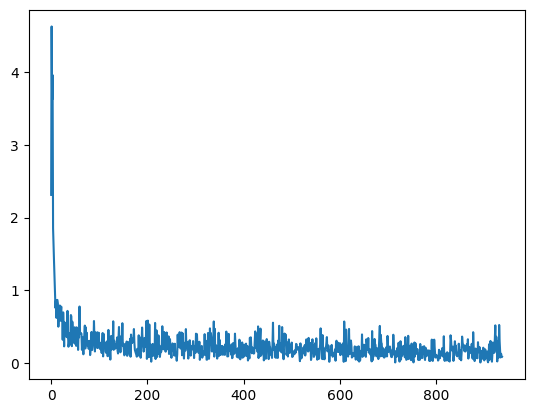

In [7]:
plt.plot(loss_history);

In [8]:
def get_acc(opt_state):
    net_params = get_params(opt_state)
    all_preds = []
    all_tgts = []

    for i, batch in enumerate(test_loader):
        X, targets = batch
        X = jnp.array(X.flatten(1, -1))
        targets = jnp.array(targets)

        logits = net_apply(net_params, X)
        preds = softmax(logits).argmax(1)
        # print(preds)

        all_preds.append(preds)
        all_tgts.append(targets)

    print(f'Test accuracy = {(jnp.concatenate(all_preds) == jnp.concatenate(all_tgts)).mean()}')

In [9]:
get_acc(opt_state)

Test accuracy = 0.9541999697685242


## Collect layer activations

In [10]:
from tqdm.notebook import tqdm
from jax.nn import relu

def apply_net_layerly(params, x):
    stats = []
    for p in params:
        if p:
            (W, b) = p
            x = x @ W + b
            stats.append(x)
            x = relu(x)
    return stats

def write_res(res, stat, i, label):
    res[label.item()].append(stat[i])
    return res

def get_stats(net_params):
    res0 = {i: [] for i in range(10)}
    res1 = {i: [] for i in range(10)}
    res2 = {i: [] for i in range(10)}

    for batch in tqdm(train_loader):
        X, targets = batch
        X = jnp.array(X.flatten(1, -1))

        stats = apply_net_layerly(net_params, X)

        for i, label in enumerate(targets):
            res0 = write_res(res0, stats[0], i, label)
            res1 = write_res(res1, stats[1], i, label)
            res2 = write_res(res2, stats[2], i, label)

    return res0, res1, res2

net_params = get_params(opt_state)
reses = get_stats(net_params)

  0%|          | 0/938 [00:00<?, ?it/s]

## Sample from distribution with empirical mean and covariance

In [66]:
import torch
import torch.utils.data as data_utils

def sample_stats(reses):
    res0, res1, res2 = reses

    mu0 = {i: np.stack(res0[i]).mean(0) / 8 for i in range(10)}
    cov0 = {i: np.cov(np.stack(res0[i]).T / 8) for i in range(10)}
    mu1 = {i: np.stack(res1[i]).mean(0) / 8 for i in range(10)}
    cov1 = {i: np.cov(np.stack(res1[i]).T / 8) for i in range(10)}
    mu2 = {i: np.stack(res2[i]).mean(0) / 8 for i in range(10)}
    cov2 = {i: np.cov(np.stack(res2[i]).T / 8) for i in range(10)}

    X = []
    y = []

    bs = 64
    num_batch = 5

    for cls in tqdm(range(10)):
        # for batch in range(num_batch):
        act0 = np.random.multivariate_normal(mu0[cls], cov0[cls], bs * num_batch)
        act1 = np.random.multivariate_normal(mu1[cls], cov1[cls], bs * num_batch)
        act2 = np.random.multivariate_normal(mu2[cls], cov2[cls], bs * num_batch)
        X.append(np.concatenate((act0, act1, act2), 1))

        y.append([cls] * num_batch * bs)

    act_x = torch.tensor(np.concatenate(X, 0)) # RELU
    act_y = torch.tensor(np.concatenate(y, 0))
    train_tensor = data_utils.TensorDataset(act_x, act_y)

    return train_tensor

sample_tensor = sample_stats(reses)
sample_loader = DataLoader(sample_tensor, batch_size=160, shuffle=False)

## Optimize the input image to create synthetic data from model activations

In [67]:
def optimize_dataset(sample_loader, ran_key, stat_type='top'):
    @jjit
    def mse_loss(x_inp, params, act_tgt):
        act_tgt = relu(act_tgt)
        if stat_type == 'top':
            stats = net_apply(params, x_inp)
            res = relu(stats)
            loss = ((stats - act_tgt[:, -10:]) ** 2).mean()
        elif stat_type == 'all':
            loss = 0
            stats = apply_net_layerly(params, x_inp)
            loss += ((relu(stats[0]) - act_tgt[:, :1200]) ** 2).mean() / 1200
            loss += ((relu(stats[1]) - act_tgt[:, 1200:2400]) ** 2).mean() / 1200
            loss += ((relu(stats[-1]) - act_tgt[:, -10:]) ** 2).mean() / 10
        return loss

    @jjit
    def train_step(step_i, opt_state, net_params, act_tgt):
        x_inp = get_params(opt_state)
        loss, grads = value_and_grad(mse_loss, argnums=0)(x_inp, net_params, act_tgt)
        return loss, opt_update(step_i, grads, opt_state)

    def optimize_batch(act_x, net_params, ran_key, bs):
        loss_history = []
        ran_key, init_key = jran.split(ran_key)
        x_inp = jran.normal(init_key, shape=(bs, 28*28))
        opt_init, opt_update, get_params = jax_opt.adam(5e-3)
        opt_state = opt_init(x_inp)
        act_x = jnp.array(act_x)

        for i in range(1000):
            loss, opt_state = train_step(i, opt_state, net_params, act_x)
            loss_history.append(float(loss))

        plt.plot(loss_history);

        return opt_state, ran_key

    new_dataset_x = []
    new_dataset_y = []

    for batch in tqdm(sample_loader):
        act_x, act_y = batch
        opt_state, ran_key = optimize_batch(act_x, net_params, ran_key, act_x.shape[0])
        new_dataset_x.append(np.clip(get_params(opt_state), 0, 1))
        new_dataset_y.append(jnp.array(act_y))

    return new_dataset_x, new_dataset_y, ran_key

### Train student model on synthetic dataset

In [148]:
def train_student(loader):
    SEED = 100
    ran_key = jran.PRNGKey(SEED)

    net_init, net_apply = stax.serial(
      stax.Dense(800), stax.Relu,
      stax.Dense(800), stax.Relu,
      stax.Dense(10),
    )

    ran_key, net_init_key = jran.split(ran_key)
    out_shape, net_params = net_init(net_init_key, input_shape=(-1, n_features))
    opt_init, opt_update, get_params = jax_opt.adam(5e-4)
    opt_state = opt_init(net_params)

    loss_history = []

    for i, batch in enumerate(loader):
        X, targets = batch
        X = jnp.array(X.flatten(1, -1))
        targets = jnp.array(targets)
        loss_data = X, targets

        params = get_params(opt_state)

        loss, opt_state = train_step(i, opt_state, loss_data)
        loss_history.append(float(loss))

    plt.plot(loss_history);

    get_acc(opt_state)

## Top-layer statistics

  0%|          | 0/20 [00:00<?, ?it/s]

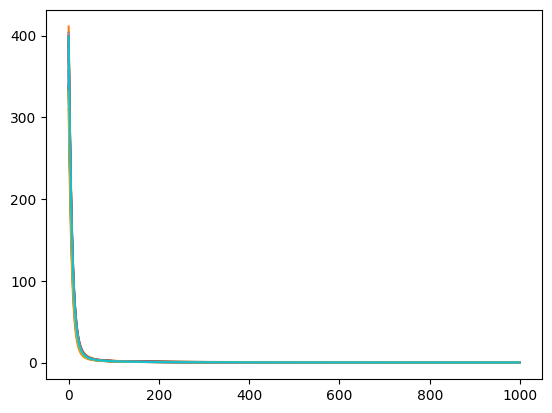

In [68]:
top_x, top_y, ran_key = optimize_dataset(sample_loader, ran_key)

In [80]:
top_tensor = data_utils.TensorDataset(torch.tensor(np.concatenate(top_x, 0)),
                                        torch.tensor(np.concatenate(top_y, 0)))

top_loader = DataLoader(top_tensor, batch_size=64, shuffle=True)

Test accuracy = 0.1776999980211258


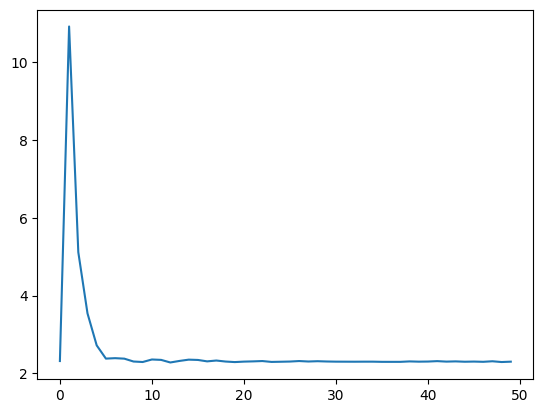

In [87]:
train_student(top_loader)

## All-layer statistics

  0%|          | 0/20 [00:00<?, ?it/s]

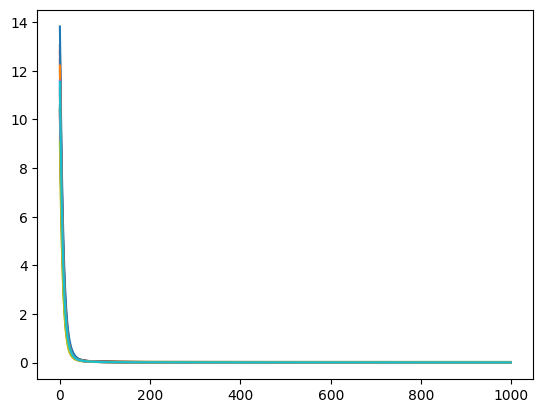

In [90]:
all_x, all_y, ran_key = optimize_dataset(sample_loader, ran_key, 'all')

In [146]:
all_tensor = data_utils.TensorDataset(torch.tensor(np.concatenate(all_x, 0)),
                                        torch.tensor(np.concatenate(all_y, 0)))

all_loader = DataLoader(all_tensor, batch_size=64, shuffle=True)

Test accuracy = 0.12299999594688416


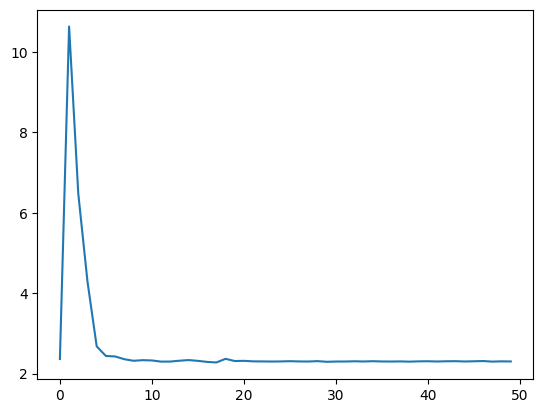

In [143]:
train_student(all_loader)

In [72]:
import pandas as pd

top_data = pd.DataFrame(np.concatenate(top_x, 0))
top_data['label'] = np.concatenate(top_y, 0)
top_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.000000,1.000000,0.042623,0.000000,0.000000,0.000000,0.000000,0.506137,0.000000,...,0.000000,0.452457,0.971896,0.042188,0.000000,0.152442,0.515296,0.285843,0.661710,0
1,0.0,0.832238,0.000000,0.000000,0.093966,0.000000,0.147181,0.000000,0.571209,0.000000,...,0.031543,0.000000,0.249694,0.612000,0.838680,0.000000,0.000000,0.000000,0.000000,0
2,0.0,0.000000,0.246725,0.306647,0.000000,0.000000,0.000000,0.229548,0.349275,0.874352,...,1.000000,1.000000,0.000000,0.062758,0.000000,0.000000,1.000000,0.541032,0.000000,0
3,0.0,0.000000,0.000000,0.302835,0.701382,0.000000,0.000000,0.000000,0.078321,0.732622,...,0.000000,0.676760,1.000000,0.000000,0.000000,0.000000,0.595374,0.000000,0.352988,0
4,1.0,1.000000,0.928392,0.000000,0.000000,0.208436,0.046245,1.000000,0.166099,0.067310,...,0.108793,0.000000,0.169298,0.000000,0.155799,0.015908,0.606749,0.000000,1.000000,0


## Means of generated dataset

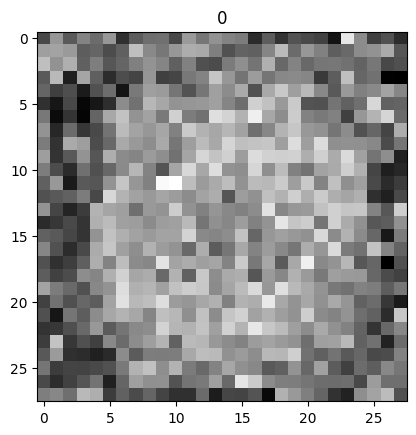

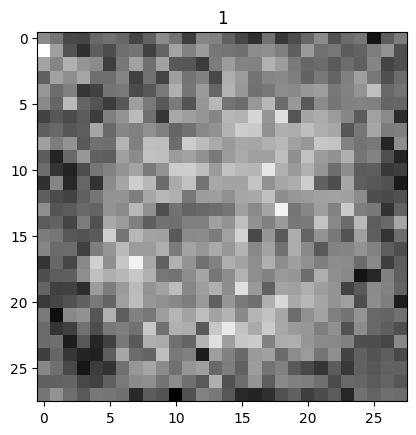

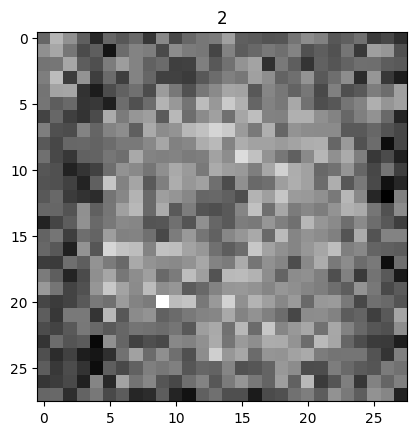

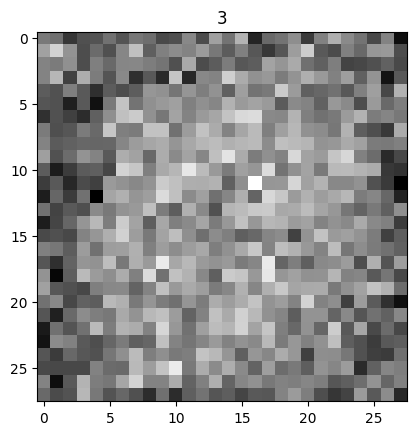

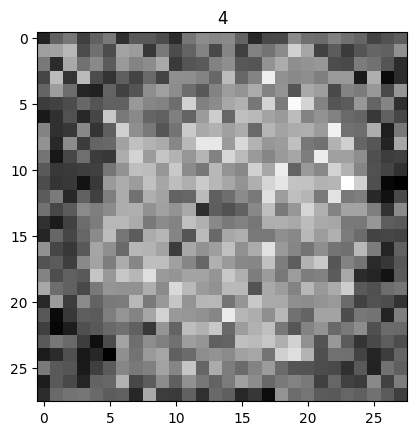

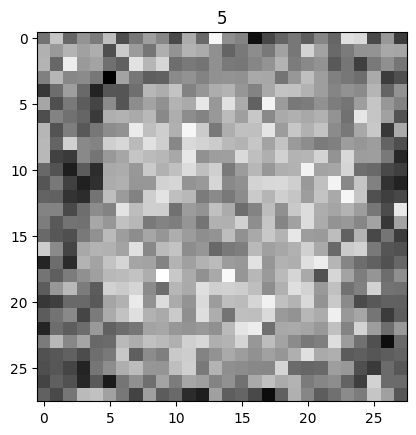

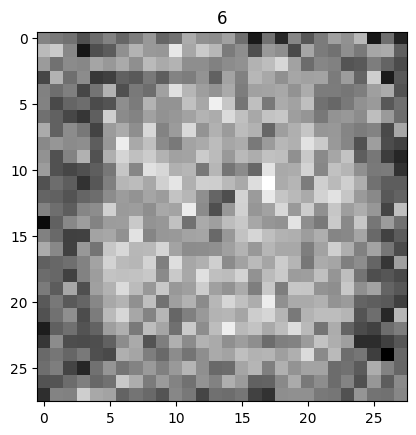

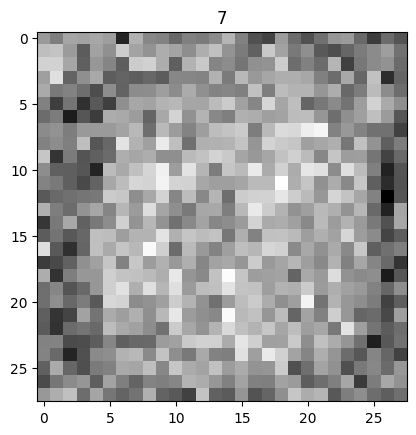

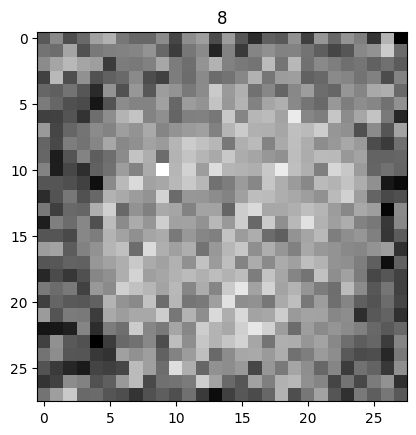

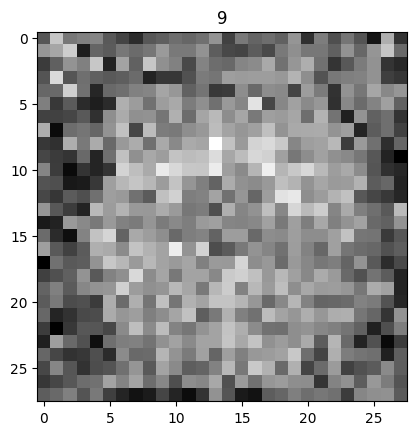

In [73]:
for i in range(10):
    plt.figure()
    plt.imshow(top_data.groupby('label').mean().iloc[i].values.reshape(28, 28, 1), cmap='gray')
    plt.title(i)

In [113]:
all_data = pd.DataFrame(np.concatenate(all_x, 0))
all_data['label'] = np.concatenate(all_y, 0)
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.000000,0.235868,1.000000,0.000000,0.543498,0.000000,0.248757,0.375537,0.618105,0.222128,...,0.067173,0.000000,0.078096,0.665472,0.409209,0.000000,0.000000,0.089392,0.000000,0
1,0.761646,0.256110,0.000000,1.000000,0.018824,0.000000,0.000000,0.774722,0.000000,0.000000,...,0.000000,0.102089,0.000000,0.000000,0.000000,0.000000,0.000000,0.755532,0.000000,0
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.608787,0.281727,0.000000,0.711518,0.000000,...,0.000000,0.717512,1.000000,0.483881,0.000000,0.264384,0.000000,1.000000,0.400816,0
3,1.000000,0.728235,0.232385,0.554479,0.172066,0.000000,0.606315,0.000000,0.929640,0.189241,...,1.000000,0.132910,0.000000,0.000000,0.000000,0.093450,1.000000,0.887271,0.000000,0
4,0.828999,0.000000,0.000000,0.429043,0.933856,0.568255,0.284487,0.000000,0.000000,0.232611,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138105,0.000000,0.681292,0


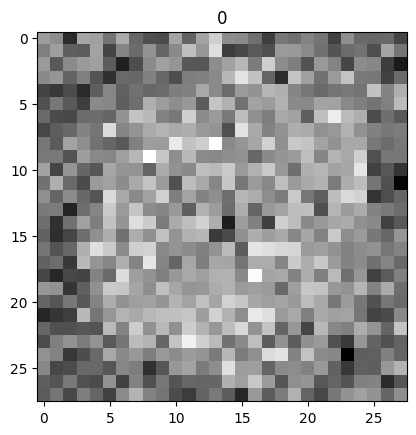

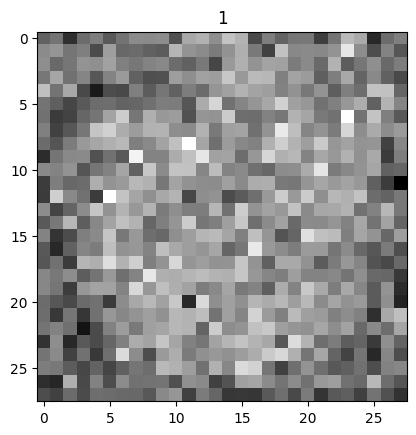

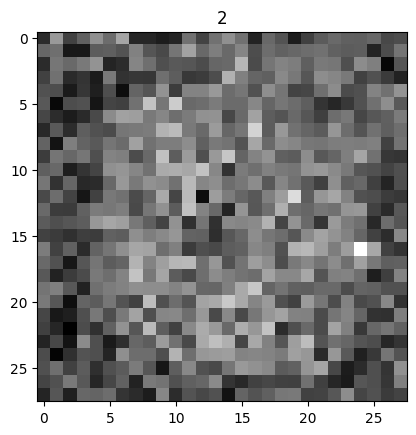

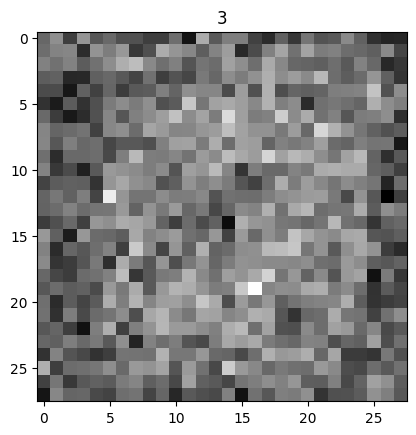

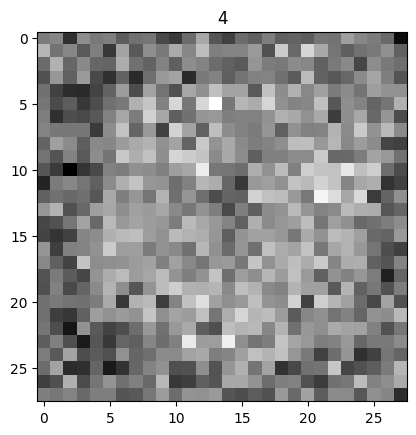

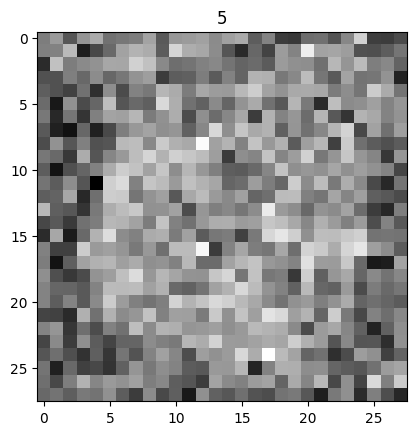

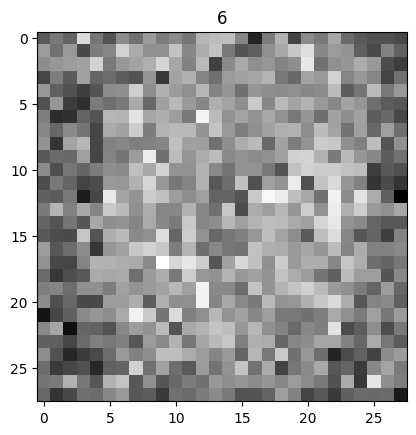

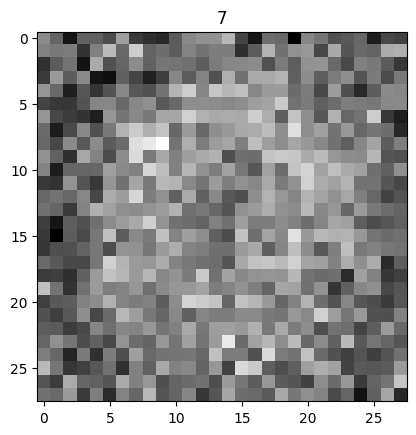

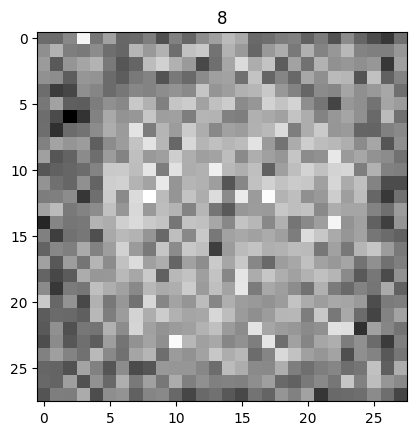

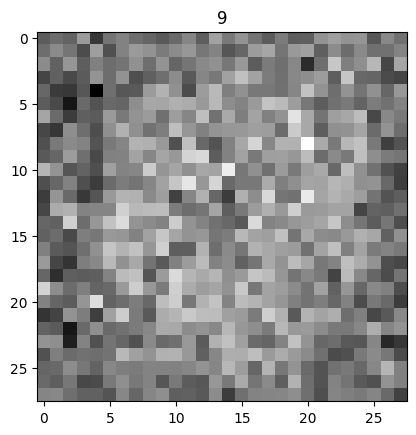

In [114]:
for i in range(10):
    plt.figure()
    plt.imshow(all_data.groupby('label').mean().iloc[i].values.reshape(28, 28, 1), cmap='gray')
    plt.title(i)

I could not achieve metrics reported in the article. However, the test results show that training on a synthetic dataset improves accuracy compared to a random guess. Using all layer statistics gives worse results, but it repends on the random seed